In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping
import pandas as pd

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
plt.rcParams.update({'font.size': 18})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [4]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'

In [5]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [100]:
# Input data files

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_standardized_reconstr_1500_0.nc')
flux_reconstr0 = flux_reconstr0.reconstructed_data

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_standardized_reconstr_1500_1.nc')
flux_reconstr1 = flux_reconstr1.reconstructed_data

flux_reconstr2 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_standardized_reconstr_1500_2.nc')
flux_reconstr2 = flux_reconstr2.reconstructed_data

flux_reconstr3 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_standardized_reconstr_1500_3.nc')
flux_reconstr3 = flux_reconstr3.reconstructed_data

flux_reconstr4 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_standardized_reconstr_1500_4.nc')
flux_reconstr4 = flux_reconstr4.reconstructed_data

catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
eofs = xr.open_dataset(inDirName+interim_data_folder+"fluxclean_eofs.nc")
pcs = xr.open_dataset(inDirName+interim_data_folder+"fluxclean_pcs.nc")
varexpl = xr.open_dataset(inDirName+interim_data_folder+"fluxclean_varexpl.nc")

In [7]:
flux_clean_ts = flux_clean.sum(['y','x'])

In [10]:
flux_clean_mean = flux_clean.mean('time')

In [13]:
flux_clean_std = flux_clean.std('time')

In [15]:
flux_clean_standardized = (flux_clean - flux_clean_mean)/flux_clean_std

In [38]:
flux_clean_standardized_ts = flux_clean_standardized.sum(['y','x'])

Text(0.5, 0, 'Time (months)')

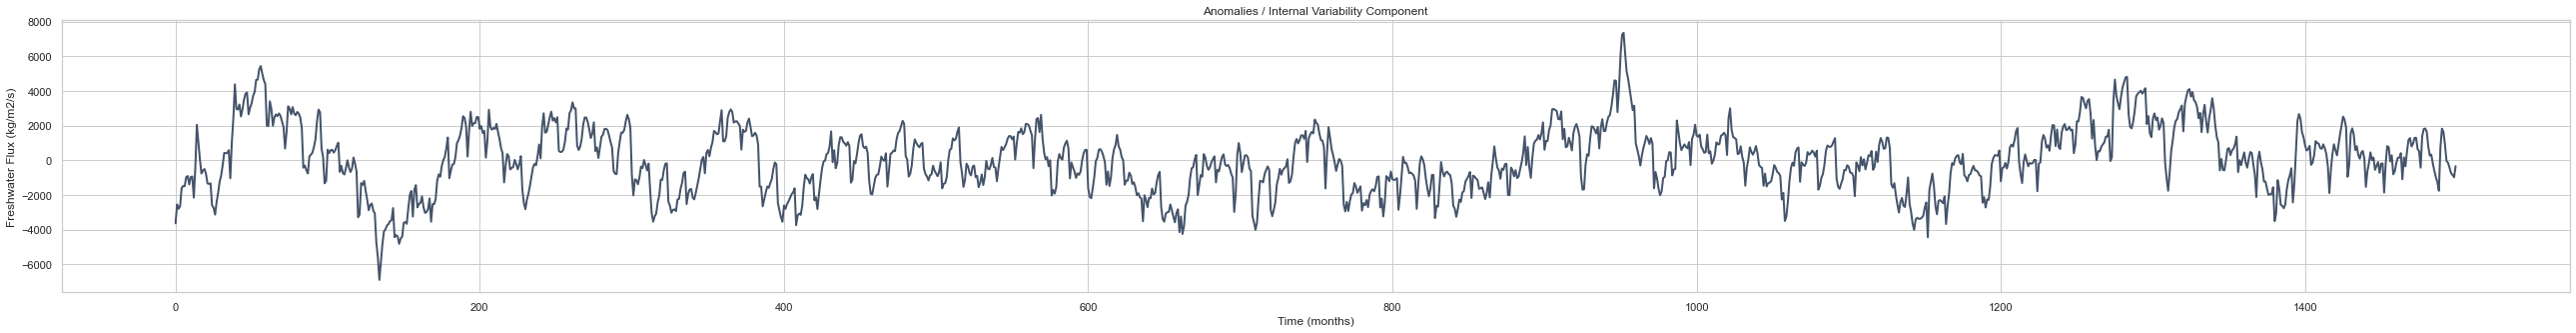

In [40]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
#plt.plot(flux_anm_ts)
plt.plot(flux_clean_standardized_ts[:], color = '#44546A', linewidth=2)
plt.title('Anomalies / Internal Variability Component: Standardized')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

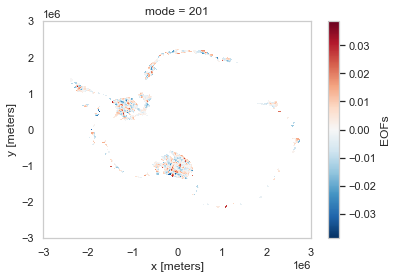

In [47]:
eofs[:,:,200].plot()

In [25]:
nmodes = model.n_modes

Text(0.5, 0, 'Time (months)')

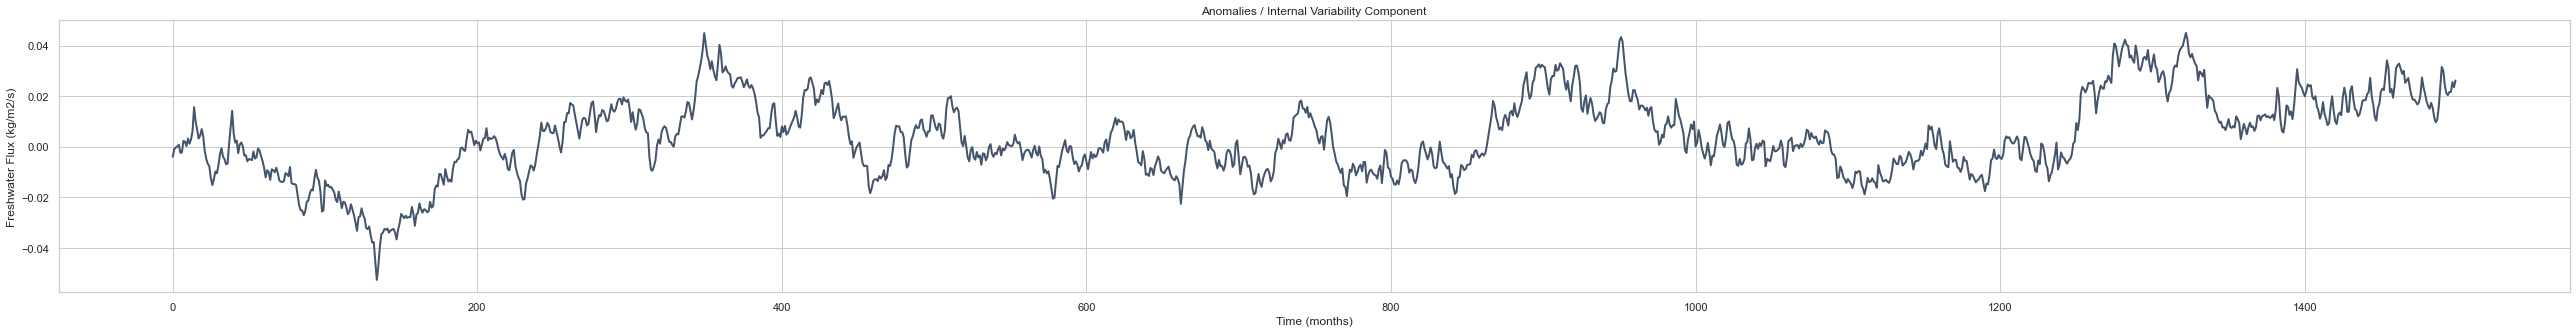

In [44]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
#plt.plot(flux_anm_ts)
plt.plot(flux_clean_ts[:], color = '#44546A', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

## Spatial Decomposition: EOFs

In [20]:
%%time
model = EOF(flux_clean_standardized)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 55.4 s, sys: 24 s, total: 1min 19s
Wall time: 27.1 s


In [11]:
#eofs.to_netcdf(inDirName+interim_data_folder+"fluxclean_eofs.nc")
#pcs.to_netcdf(inDirName+interim_data_folder+"fluxclean_pcs.nc")
#varexpl.to_netcdf(inDirName+interim_data_folder+"fluxclean_varexpl.nc")

Text(0.5, 1.0, 'Total Relative Power of first 350 EOFs: 98.09504489825125')

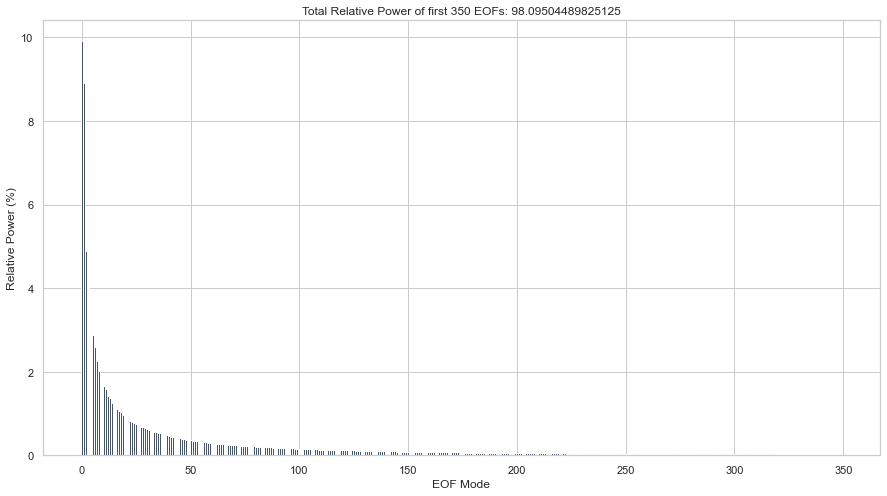

In [37]:
# Figure: Relative power of m EOFs

m = 350
plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, color='#44546A')
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs: {}'.format(m,varexpl[:m].sum().values*100))

In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)

0           Filchner-Ronne
1                     Ross
2               Antarctica
3                Peninsula
4          West Antarctica
5          East Antarctica
6                   IMBIE1
7                   IMBIE2
8                   IMBIE3
9                   IMBIE4
10                  IMBIE5
11                  IMBIE6
12                  IMBIE7
13                  IMBIE8
14                  IMBIE9
15                 IMBIE10
16                 IMBIE11
17                 IMBIE12
18                 IMBIE13
19                 IMBIE14
20                 IMBIE15
21                 IMBIE16
22                 IMBIE17
23                 IMBIE18
24                 IMBIE19
25                 IMBIE20
26                 IMBIE21
27                 IMBIE22
28                 IMBIE23
29                 IMBIE24
30                 IMBIE25
31                 IMBIE26
32                 IMBIE27
33                   Abbot
34                   Amery
35                    Atka
36                 Aviator
3

In [24]:
snscolors = sns.color_palette("deep")

<Axes:label='inset_axes'>

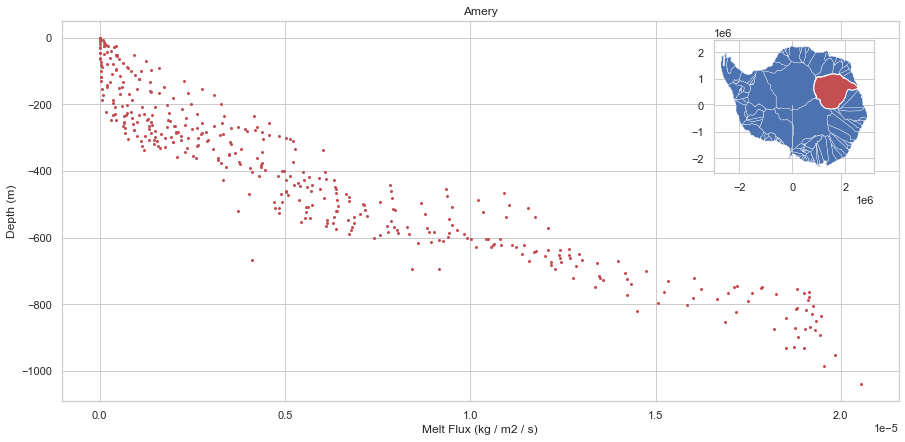

In [7]:
# Figure: Melt rate draft dependence for select catchments
catchment_number = 1 # Select in [0,99]

# Amery = 1, Thwaites = 81, Filchner = 22, Ronne = 70, Eastern_Ross = 72, Western_Ross = 71

#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, ax = plt.subplots(1, 1, figsize=[15, 7])
#axins = inset_axes(ax, width="20%", height="20%")
axins = ax.inset_axes([0.65, 0.6, 0.45, 0.35])

ax.scatter(catchments_scatter[catchment_number],ssh[1],color='r',s=4)
ax.set_xlabel('Melt Flux (kg / m2 / s)')
ax.set_ylabel('Depth (m)')
ax.set_title(icems.name[33+catchment_number])

icems[33:133].plot(ax=axins,linewidth=0.3)
#axins.coastlines(resolution='10m', zorder=6,linewidth=0.5)
icems.loc[[33+catchment_number],'geometry'].plot(ax=axins,color='r')

# TODO: Polar Stereographic Projection for inset map
# TODO: Convert to m SLE units for flux

In [48]:
abs_max = np.amax(np.abs(eofs))
eof_norm = eofs*1.0/abs_max

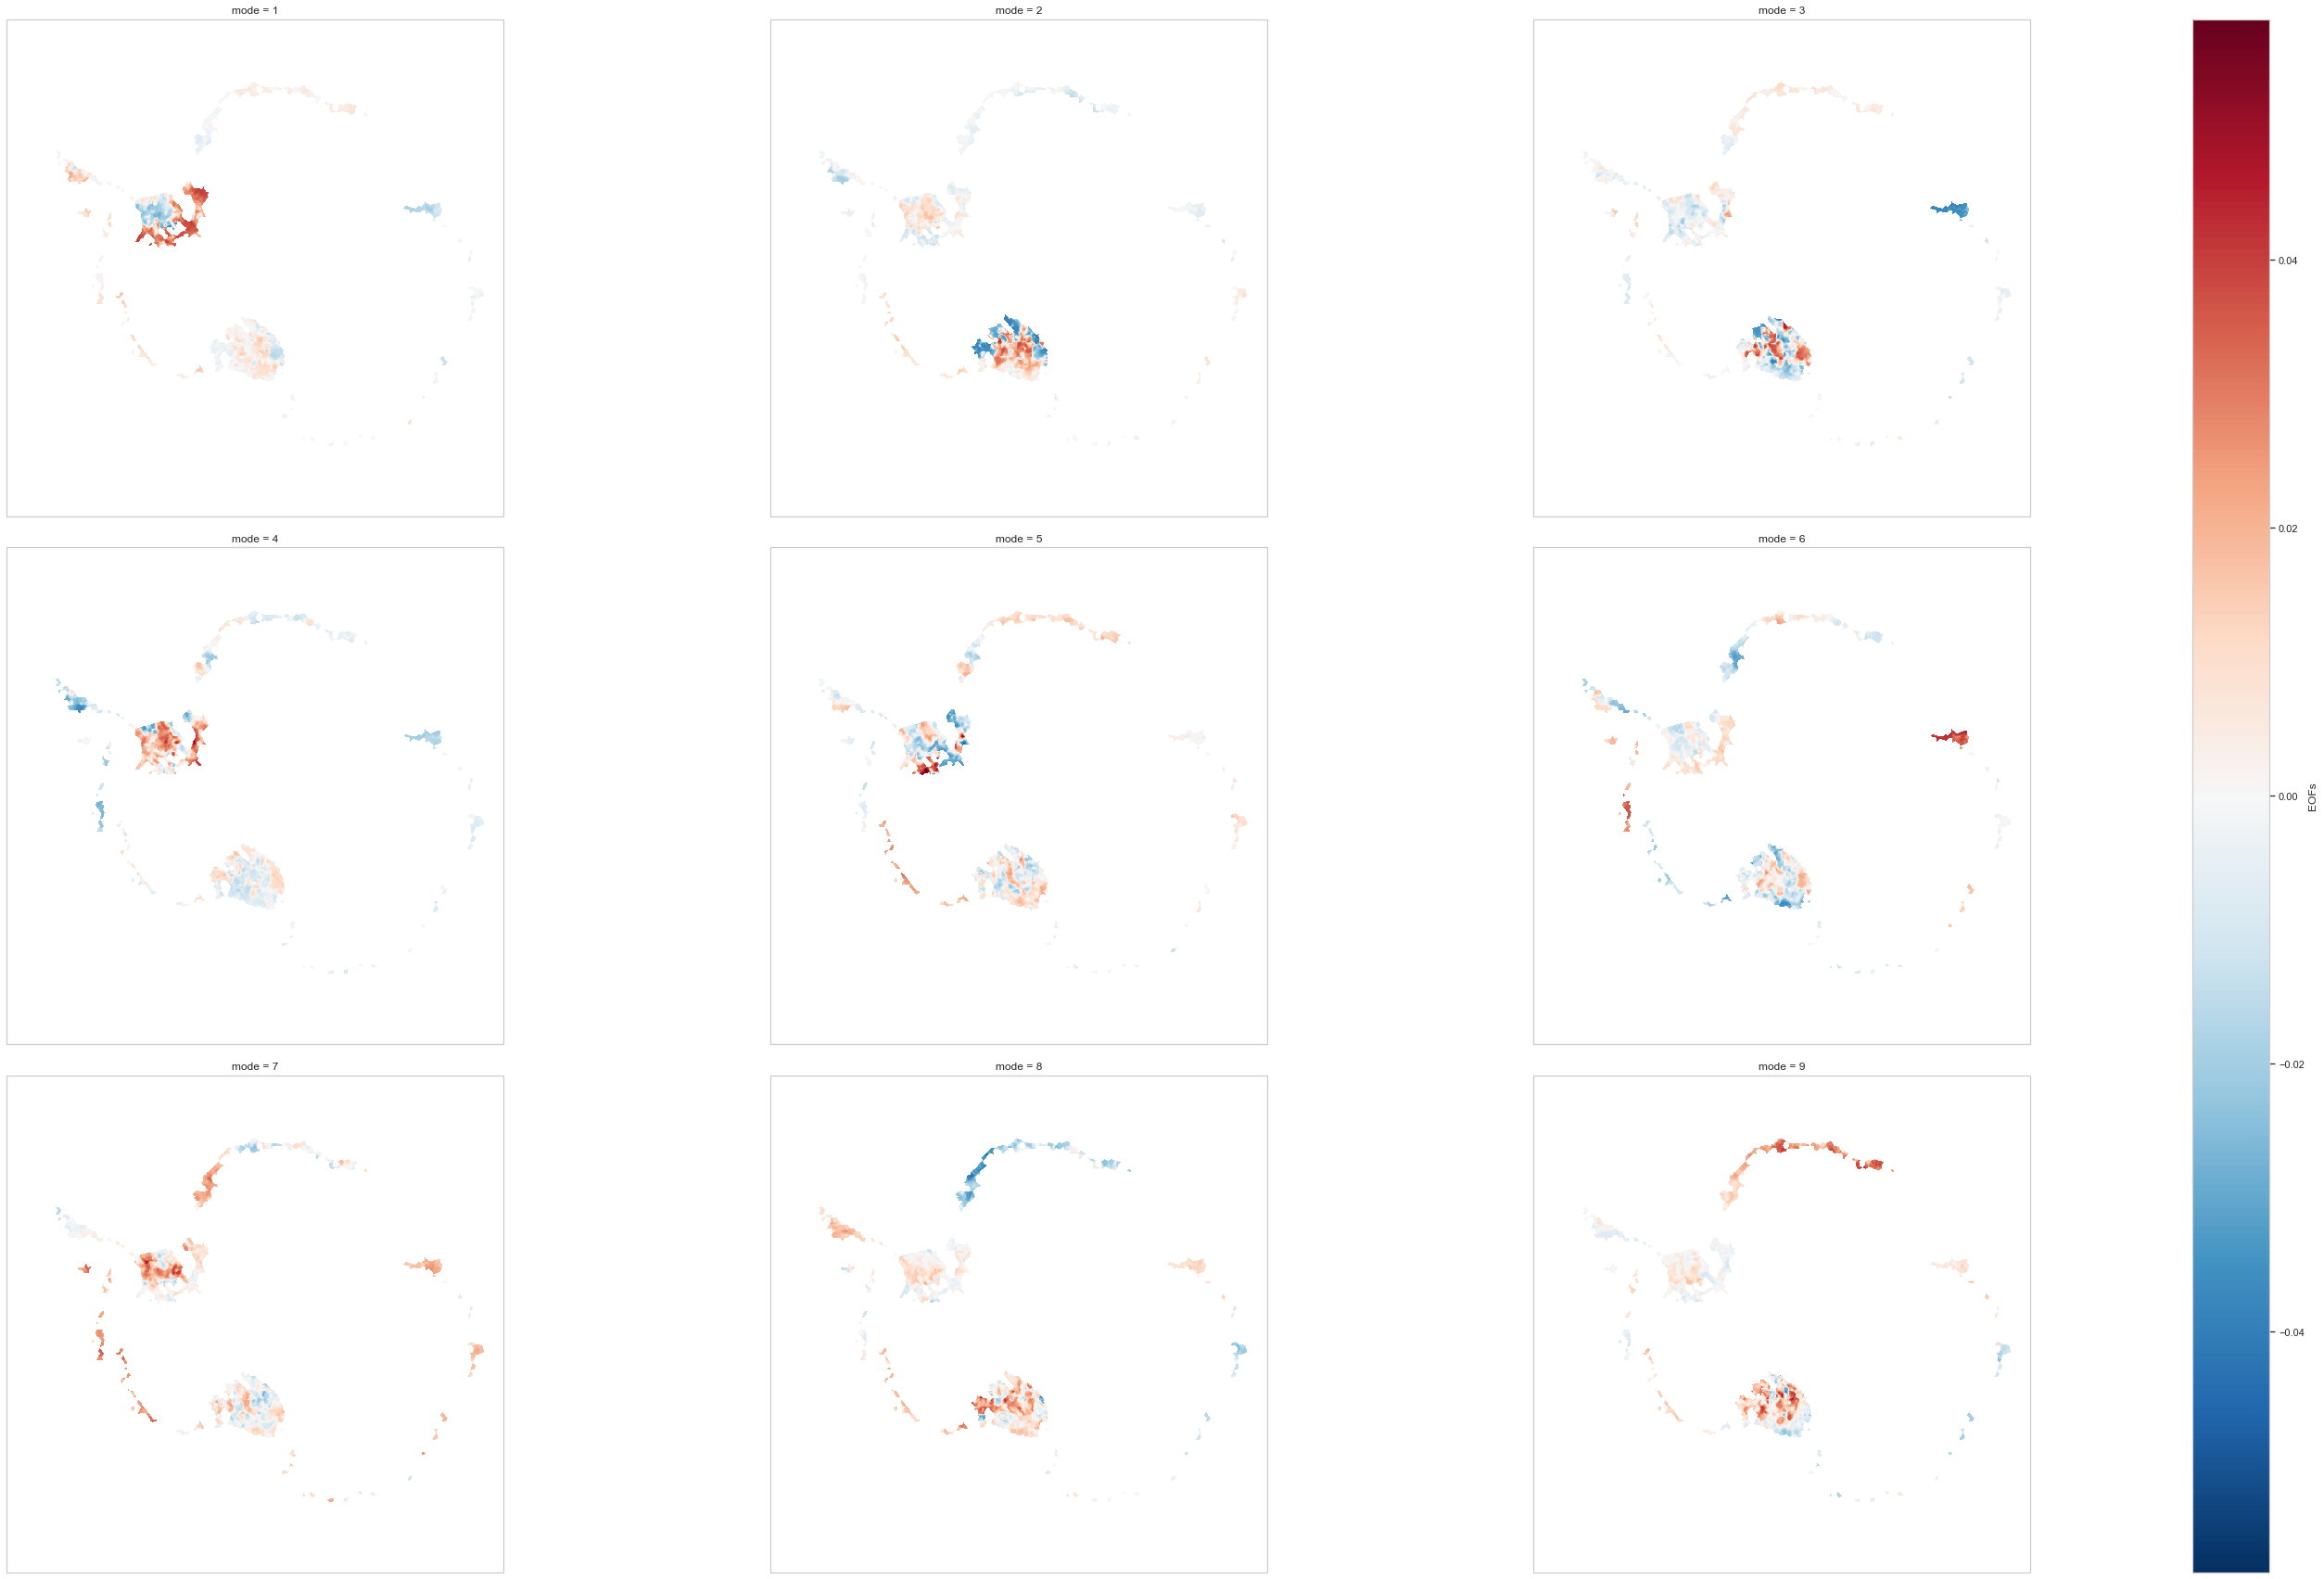

In [50]:
# Figure: Dominant EOF modes
fg = eof_norm[:,:,0:9].plot(aspect=2,
                            size=8,
                            col="mode", 
                            col_wrap=3,
                            subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

## Fourier Phase Randomization

In [54]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 5
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}, mode: {}'.format(i,m))

calculated ifft for realization 0, mode: 0
calculated ifft for realization 0, mode: 1
calculated ifft for realization 0, mode: 2
calculated ifft for realization 0, mode: 3
calculated ifft for realization 0, mode: 4
calculated ifft for realization 0, mode: 5
calculated ifft for realization 0, mode: 6
calculated ifft for realization 0, mode: 7
calculated ifft for realization 0, mode: 8
calculated ifft for realization 0, mode: 9
calculated ifft for realization 0, mode: 10
calculated ifft for realization 0, mode: 11
calculated ifft for realization 0, mode: 12
calculated ifft for realization 0, mode: 13
calculated ifft for realization 0, mode: 14
calculated ifft for realization 0, mode: 15
calculated ifft for realization 0, mode: 16
calculated ifft for realization 0, mode: 17
calculated ifft for realization 0, mode: 18
calculated ifft for realization 0, mode: 19
calculated ifft for realization 0, mode: 20
calculated ifft for realization 0, mode: 21
calculated ifft for realization 0, mode: 2

calculated ifft for realization 0, mode: 590
calculated ifft for realization 0, mode: 591
calculated ifft for realization 0, mode: 592
calculated ifft for realization 0, mode: 593
calculated ifft for realization 0, mode: 594
calculated ifft for realization 0, mode: 595
calculated ifft for realization 0, mode: 596
calculated ifft for realization 0, mode: 597
calculated ifft for realization 0, mode: 598
calculated ifft for realization 0, mode: 599
calculated ifft for realization 0, mode: 600
calculated ifft for realization 0, mode: 601
calculated ifft for realization 0, mode: 602
calculated ifft for realization 0, mode: 603
calculated ifft for realization 0, mode: 604
calculated ifft for realization 0, mode: 605
calculated ifft for realization 0, mode: 606
calculated ifft for realization 0, mode: 607
calculated ifft for realization 0, mode: 608
calculated ifft for realization 0, mode: 609
calculated ifft for realization 0, mode: 610
calculated ifft for realization 0, mode: 611
calculated

calculated ifft for realization 0, mode: 1185
calculated ifft for realization 0, mode: 1186
calculated ifft for realization 0, mode: 1187
calculated ifft for realization 0, mode: 1188
calculated ifft for realization 0, mode: 1189
calculated ifft for realization 0, mode: 1190
calculated ifft for realization 0, mode: 1191
calculated ifft for realization 0, mode: 1192
calculated ifft for realization 0, mode: 1193
calculated ifft for realization 0, mode: 1194
calculated ifft for realization 0, mode: 1195
calculated ifft for realization 0, mode: 1196
calculated ifft for realization 0, mode: 1197
calculated ifft for realization 0, mode: 1198
calculated ifft for realization 0, mode: 1199
calculated ifft for realization 0, mode: 1200
calculated ifft for realization 0, mode: 1201
calculated ifft for realization 0, mode: 1202
calculated ifft for realization 0, mode: 1203
calculated ifft for realization 0, mode: 1204
calculated ifft for realization 0, mode: 1205
calculated ifft for realization 0,

calculated ifft for realization 1, mode: 296
calculated ifft for realization 1, mode: 297
calculated ifft for realization 1, mode: 298
calculated ifft for realization 1, mode: 299
calculated ifft for realization 1, mode: 300
calculated ifft for realization 1, mode: 301
calculated ifft for realization 1, mode: 302
calculated ifft for realization 1, mode: 303
calculated ifft for realization 1, mode: 304
calculated ifft for realization 1, mode: 305
calculated ifft for realization 1, mode: 306
calculated ifft for realization 1, mode: 307
calculated ifft for realization 1, mode: 308
calculated ifft for realization 1, mode: 309
calculated ifft for realization 1, mode: 310
calculated ifft for realization 1, mode: 311
calculated ifft for realization 1, mode: 312
calculated ifft for realization 1, mode: 313
calculated ifft for realization 1, mode: 314
calculated ifft for realization 1, mode: 315
calculated ifft for realization 1, mode: 316
calculated ifft for realization 1, mode: 317
calculated

calculated ifft for realization 1, mode: 905
calculated ifft for realization 1, mode: 906
calculated ifft for realization 1, mode: 907
calculated ifft for realization 1, mode: 908
calculated ifft for realization 1, mode: 909
calculated ifft for realization 1, mode: 910
calculated ifft for realization 1, mode: 911
calculated ifft for realization 1, mode: 912
calculated ifft for realization 1, mode: 913
calculated ifft for realization 1, mode: 914
calculated ifft for realization 1, mode: 915
calculated ifft for realization 1, mode: 916
calculated ifft for realization 1, mode: 917
calculated ifft for realization 1, mode: 918
calculated ifft for realization 1, mode: 919
calculated ifft for realization 1, mode: 920
calculated ifft for realization 1, mode: 921
calculated ifft for realization 1, mode: 922
calculated ifft for realization 1, mode: 923
calculated ifft for realization 1, mode: 924
calculated ifft for realization 1, mode: 925
calculated ifft for realization 1, mode: 926
calculated

calculated ifft for realization 2, mode: 0
calculated ifft for realization 2, mode: 1
calculated ifft for realization 2, mode: 2
calculated ifft for realization 2, mode: 3
calculated ifft for realization 2, mode: 4
calculated ifft for realization 2, mode: 5
calculated ifft for realization 2, mode: 6
calculated ifft for realization 2, mode: 7
calculated ifft for realization 2, mode: 8
calculated ifft for realization 2, mode: 9
calculated ifft for realization 2, mode: 10
calculated ifft for realization 2, mode: 11
calculated ifft for realization 2, mode: 12
calculated ifft for realization 2, mode: 13
calculated ifft for realization 2, mode: 14
calculated ifft for realization 2, mode: 15
calculated ifft for realization 2, mode: 16
calculated ifft for realization 2, mode: 17
calculated ifft for realization 2, mode: 18
calculated ifft for realization 2, mode: 19
calculated ifft for realization 2, mode: 20
calculated ifft for realization 2, mode: 21
calculated ifft for realization 2, mode: 2

calculated ifft for realization 2, mode: 594
calculated ifft for realization 2, mode: 595
calculated ifft for realization 2, mode: 596
calculated ifft for realization 2, mode: 597
calculated ifft for realization 2, mode: 598
calculated ifft for realization 2, mode: 599
calculated ifft for realization 2, mode: 600
calculated ifft for realization 2, mode: 601
calculated ifft for realization 2, mode: 602
calculated ifft for realization 2, mode: 603
calculated ifft for realization 2, mode: 604
calculated ifft for realization 2, mode: 605
calculated ifft for realization 2, mode: 606
calculated ifft for realization 2, mode: 607
calculated ifft for realization 2, mode: 608
calculated ifft for realization 2, mode: 609
calculated ifft for realization 2, mode: 610
calculated ifft for realization 2, mode: 611
calculated ifft for realization 2, mode: 612
calculated ifft for realization 2, mode: 613
calculated ifft for realization 2, mode: 614
calculated ifft for realization 2, mode: 615
calculated

calculated ifft for realization 2, mode: 1203
calculated ifft for realization 2, mode: 1204
calculated ifft for realization 2, mode: 1205
calculated ifft for realization 2, mode: 1206
calculated ifft for realization 2, mode: 1207
calculated ifft for realization 2, mode: 1208
calculated ifft for realization 2, mode: 1209
calculated ifft for realization 2, mode: 1210
calculated ifft for realization 2, mode: 1211
calculated ifft for realization 2, mode: 1212
calculated ifft for realization 2, mode: 1213
calculated ifft for realization 2, mode: 1214
calculated ifft for realization 2, mode: 1215
calculated ifft for realization 2, mode: 1216
calculated ifft for realization 2, mode: 1217
calculated ifft for realization 2, mode: 1218
calculated ifft for realization 2, mode: 1219
calculated ifft for realization 2, mode: 1220
calculated ifft for realization 2, mode: 1221
calculated ifft for realization 2, mode: 1222
calculated ifft for realization 2, mode: 1223
calculated ifft for realization 2,

calculated ifft for realization 3, mode: 300
calculated ifft for realization 3, mode: 301
calculated ifft for realization 3, mode: 302
calculated ifft for realization 3, mode: 303
calculated ifft for realization 3, mode: 304
calculated ifft for realization 3, mode: 305
calculated ifft for realization 3, mode: 306
calculated ifft for realization 3, mode: 307
calculated ifft for realization 3, mode: 308
calculated ifft for realization 3, mode: 309
calculated ifft for realization 3, mode: 310
calculated ifft for realization 3, mode: 311
calculated ifft for realization 3, mode: 312
calculated ifft for realization 3, mode: 313
calculated ifft for realization 3, mode: 314
calculated ifft for realization 3, mode: 315
calculated ifft for realization 3, mode: 316
calculated ifft for realization 3, mode: 317
calculated ifft for realization 3, mode: 318
calculated ifft for realization 3, mode: 319
calculated ifft for realization 3, mode: 320
calculated ifft for realization 3, mode: 321
calculated

calculated ifft for realization 3, mode: 882
calculated ifft for realization 3, mode: 883
calculated ifft for realization 3, mode: 884
calculated ifft for realization 3, mode: 885
calculated ifft for realization 3, mode: 886
calculated ifft for realization 3, mode: 887
calculated ifft for realization 3, mode: 888
calculated ifft for realization 3, mode: 889
calculated ifft for realization 3, mode: 890
calculated ifft for realization 3, mode: 891
calculated ifft for realization 3, mode: 892
calculated ifft for realization 3, mode: 893
calculated ifft for realization 3, mode: 894
calculated ifft for realization 3, mode: 895
calculated ifft for realization 3, mode: 896
calculated ifft for realization 3, mode: 897
calculated ifft for realization 3, mode: 898
calculated ifft for realization 3, mode: 899
calculated ifft for realization 3, mode: 900
calculated ifft for realization 3, mode: 901
calculated ifft for realization 3, mode: 902
calculated ifft for realization 3, mode: 903
calculated

calculated ifft for realization 3, mode: 1457
calculated ifft for realization 3, mode: 1458
calculated ifft for realization 3, mode: 1459
calculated ifft for realization 3, mode: 1460
calculated ifft for realization 3, mode: 1461
calculated ifft for realization 3, mode: 1462
calculated ifft for realization 3, mode: 1463
calculated ifft for realization 3, mode: 1464
calculated ifft for realization 3, mode: 1465
calculated ifft for realization 3, mode: 1466
calculated ifft for realization 3, mode: 1467
calculated ifft for realization 3, mode: 1468
calculated ifft for realization 3, mode: 1469
calculated ifft for realization 3, mode: 1470
calculated ifft for realization 3, mode: 1471
calculated ifft for realization 3, mode: 1472
calculated ifft for realization 3, mode: 1473
calculated ifft for realization 3, mode: 1474
calculated ifft for realization 3, mode: 1475
calculated ifft for realization 3, mode: 1476
calculated ifft for realization 3, mode: 1477
calculated ifft for realization 3,

calculated ifft for realization 4, mode: 533
calculated ifft for realization 4, mode: 534
calculated ifft for realization 4, mode: 535
calculated ifft for realization 4, mode: 536
calculated ifft for realization 4, mode: 537
calculated ifft for realization 4, mode: 538
calculated ifft for realization 4, mode: 539
calculated ifft for realization 4, mode: 540
calculated ifft for realization 4, mode: 541
calculated ifft for realization 4, mode: 542
calculated ifft for realization 4, mode: 543
calculated ifft for realization 4, mode: 544
calculated ifft for realization 4, mode: 545
calculated ifft for realization 4, mode: 546
calculated ifft for realization 4, mode: 547
calculated ifft for realization 4, mode: 548
calculated ifft for realization 4, mode: 549
calculated ifft for realization 4, mode: 550
calculated ifft for realization 4, mode: 551
calculated ifft for realization 4, mode: 552
calculated ifft for realization 4, mode: 553
calculated ifft for realization 4, mode: 554
calculated

calculated ifft for realization 4, mode: 1139
calculated ifft for realization 4, mode: 1140
calculated ifft for realization 4, mode: 1141
calculated ifft for realization 4, mode: 1142
calculated ifft for realization 4, mode: 1143
calculated ifft for realization 4, mode: 1144
calculated ifft for realization 4, mode: 1145
calculated ifft for realization 4, mode: 1146
calculated ifft for realization 4, mode: 1147
calculated ifft for realization 4, mode: 1148
calculated ifft for realization 4, mode: 1149
calculated ifft for realization 4, mode: 1150
calculated ifft for realization 4, mode: 1151
calculated ifft for realization 4, mode: 1152
calculated ifft for realization 4, mode: 1153
calculated ifft for realization 4, mode: 1154
calculated ifft for realization 4, mode: 1155
calculated ifft for realization 4, mode: 1156
calculated ifft for realization 4, mode: 1157
calculated ifft for realization 4, mode: 1158
calculated ifft for realization 4, mode: 1159
calculated ifft for realization 4,

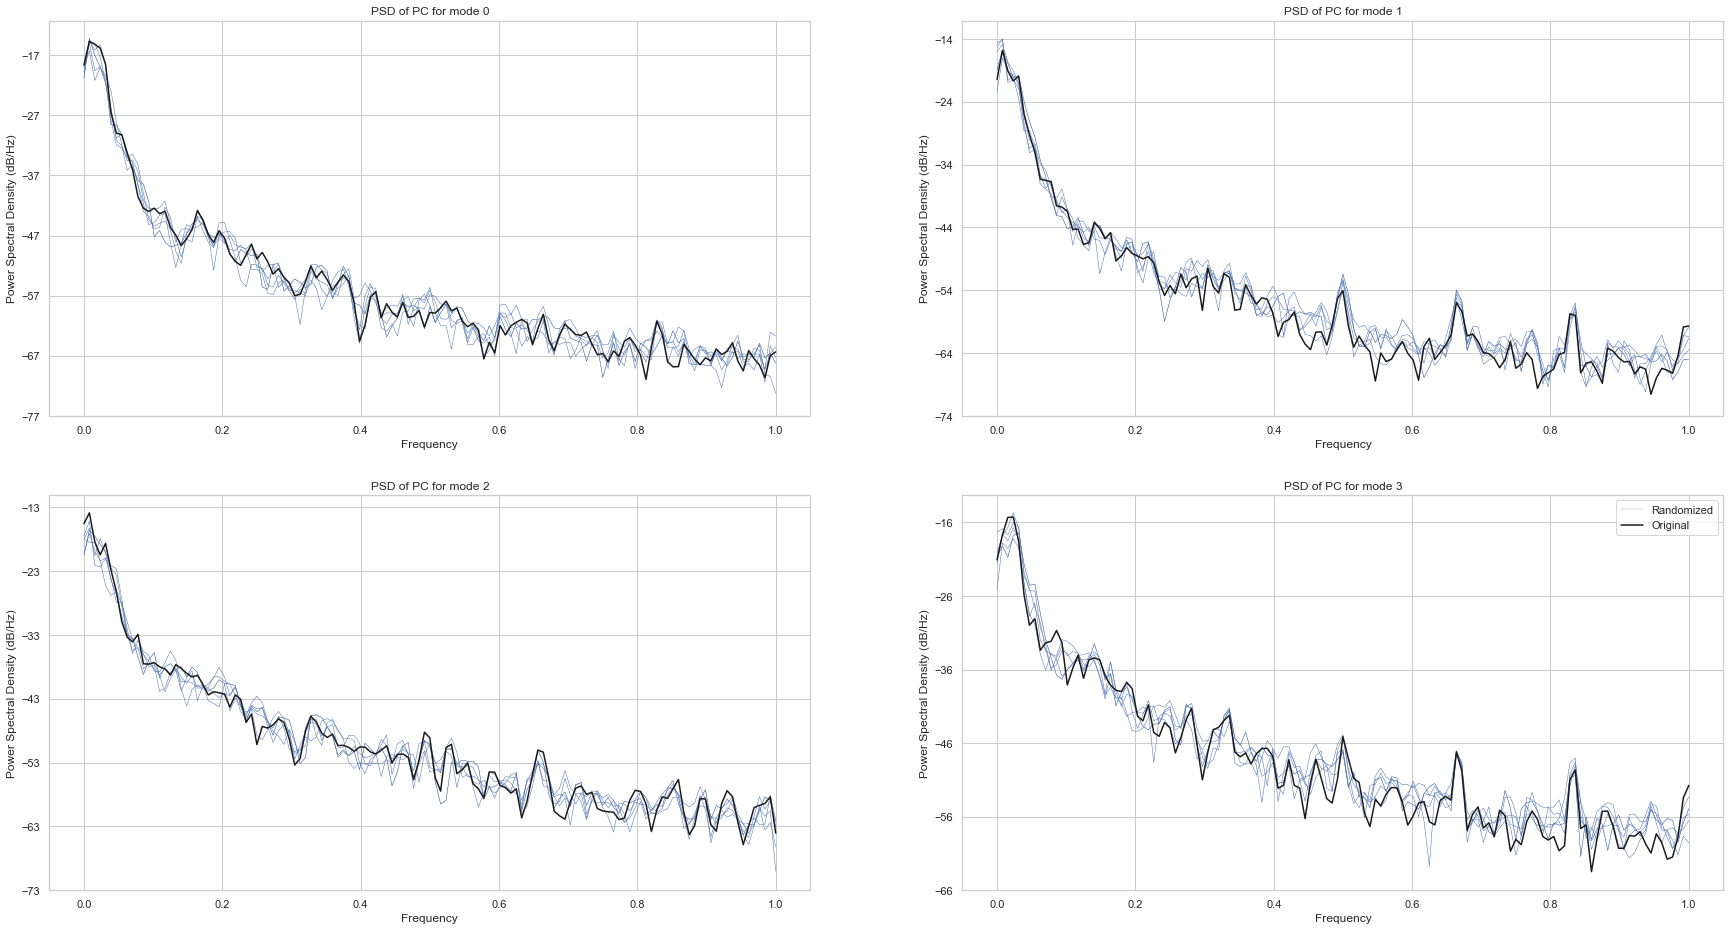

In [56]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,5):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(pcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()

In [57]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [58]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [59]:
# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [60]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

In [202]:
clipped_amery = clip_data(flux_clean, 34)

In [61]:
# Generate dataset realizations
for i in range(n_realizations):
    flux_reconstr = generate_data(i, 1500, 1)
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+cise_file_path+"flux_standardized_reconstr_1500_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

reconstructed realization # 0
reconstructed realization # 1
reconstructed realization # 2
reconstructed realization # 3
reconstructed realization # 4


In [62]:
basins = np.array((34,55,114,103,104,105))

In [102]:
for basin in basins:
    orig = clip_data(flux_clean_standardized, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    rec2 = clip_data(flux_reconstr2, basin)
    rec3 = clip_data(flux_reconstr3, basin)
    rec4 = clip_data(flux_reconstr4, basin)
    orig.to_netcdf(inDirName+interim_data_folder+cise_file_path+"orig_m1500_std_{}".format(basin))
    rec0.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec0_m1500_std_{}".format(basin))
    rec1.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec1_m1500_std_{}".format(basin))
    rec2.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec2_m1500_std_{}".format(basin))
    rec3.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec3_m1500_std_{}".format(basin))
    rec4.to_netcdf(inDirName+interim_data_folder+cise_file_path+"rec4_m1500_std_{}".format(basin))
    del orig, rec0, rec1, rec2, rec3, rec4
    gc.collect()

In [103]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m1500_std_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m1500_std_34")
rec1_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m1500_std_34")
rec2_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m1500_std_34")
rec3_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m1500_std_34")
rec4_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m1500_std_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m1500_std_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m1500_std_55")
rec1_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m1500_std_55")
rec2_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m1500_std_55")
rec3_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m1500_std_55")
rec4_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m1500_std_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m1500_std_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m1500_std_114")
rec1_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m1500_std_114")
rec2_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m1500_std_114")
rec3_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m1500_std_114")
rec4_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m1500_std_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m1500_std_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m1500_std_103")
rec1_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m1500_std_103")
rec2_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m1500_std_103")
rec3_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m1500_std_103")
rec4_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m1500_std_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m1500_std_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m1500_std_104")
rec1_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m1500_std_104")
rec2_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m1500_std_104")
rec3_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m1500_std_104")
rec4_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m1500_std_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m1500_std_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m1500_std_105")
rec1_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m1500_std_105")
rec2_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m1500_std_105")
rec3_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m1500_std_105")
rec4_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m1500_std_105")

In [108]:
rec0_34 = (rec0_34*flux_clean_std) + flux_clean_mean

In [109]:
rec0_34_ts = time_series(rec0_34)

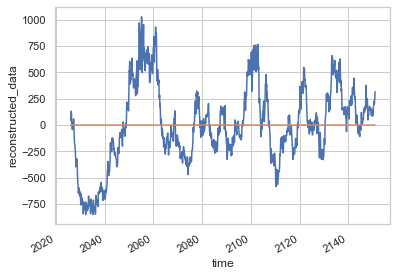

In [110]:
orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux.plot()
rec0_34_ts.reconstructed_data.plot()

In [104]:
# Amery 
orig_34_ts = time_series(orig_34)
rec0_34_ts = time_series(rec0_34)
rec1_34_ts = time_series(rec1_34)
rec2_34_ts = time_series(rec2_34)
rec3_34_ts = time_series(rec3_34)
rec4_34_ts = time_series(rec4_34)

# Filchner 
orig_55_ts = time_series(orig_55)
rec0_55_ts = time_series(rec0_55)
rec1_55_ts = time_series(rec1_55)
rec2_55_ts = time_series(rec2_55)
rec3_55_ts = time_series(rec3_55)
rec4_55_ts = time_series(rec4_55)

# Thwaites 
orig_114_ts = time_series(orig_114)
rec0_114_ts = time_series(rec0_114)
rec1_114_ts = time_series(rec1_114)
rec2_114_ts = time_series(rec2_114)
rec3_114_ts = time_series(rec3_114)
rec4_114_ts = time_series(rec4_114)

# Ronne 
orig_103_ts = time_series(orig_103)
rec0_103_ts = time_series(rec0_103)
rec1_103_ts = time_series(rec1_103)
rec2_103_ts = time_series(rec2_103)
rec3_103_ts = time_series(rec3_103)
rec4_103_ts = time_series(rec4_103)

# Western Ross 
orig_104_ts = time_series(orig_104)
rec0_104_ts = time_series(rec0_104)
rec1_104_ts = time_series(rec1_104)
rec2_104_ts = time_series(rec2_104)
rec3_104_ts = time_series(rec3_104)
rec4_104_ts = time_series(rec4_104)

# Eastern Ross 
orig_105_ts = time_series(orig_105)
rec0_105_ts = time_series(rec0_105)
rec1_105_ts = time_series(rec1_105)
rec2_105_ts = time_series(rec2_105)
rec3_105_ts = time_series(rec3_105)
rec4_105_ts = time_series(rec4_105)

In [304]:
# Amery 34
orig_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_34")
rec0_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_34")
rec1_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_34")
rec2_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_34")
rec3_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_34")
rec4_m65_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_34")

# Filchner 55
orig_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_55")
rec0_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_55")
rec1_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_55")
rec2_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_55")
rec3_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_55")
rec4_m65_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_55")

# Thwaites 114
orig_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_114")
rec0_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_114")
rec1_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_114")
rec2_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_114")
rec3_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_114")
rec4_m65_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_114")

# Ronne 103
orig_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_103")
rec0_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_103")
rec1_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_103")
rec2_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_103")
rec3_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_103")
rec4_m65_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_103")

# Western Ross 104
orig_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_104")
rec0_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_104")
rec1_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_104")
rec2_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_104")
rec3_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_104")
rec4_m65_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_104")

# Eastern Ross 105
orig_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"orig_m65_105")
rec0_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec0_m65_105")
rec1_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec1_m65_105")
rec2_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec2_m65_105")
rec3_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec3_m65_105")
rec4_m65_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+"rec4_m65_105")

In [305]:
# Amery 
orig_m65_34_ts = time_series(orig_m65_34)
rec0_m65_34_ts = time_series(rec0_m65_34)
rec1_m65_34_ts = time_series(rec1_m65_34)
rec2_m65_34_ts = time_series(rec2_m65_34)
rec3_m65_34_ts = time_series(rec3_m65_34)
rec4_m65_34_ts = time_series(rec4_m65_34)

# Filchner 
orig_m65_55_ts = time_series(orig_m65_55)
rec0_m65_55_ts = time_series(rec0_m65_55)
rec1_m65_55_ts = time_series(rec1_m65_55)
rec2_m65_55_ts = time_series(rec2_m65_55)
rec3_m65_55_ts = time_series(rec3_m65_55)
rec4_m65_55_ts = time_series(rec4_m65_55)

# Thwaites 
orig_m65_114_ts = time_series(orig_m65_114)
rec0_m65_114_ts = time_series(rec0_m65_114)
rec1_m65_114_ts = time_series(rec1_m65_114)
rec2_m65_114_ts = time_series(rec2_m65_114)
rec3_m65_114_ts = time_series(rec3_m65_114)
rec4_m65_114_ts = time_series(rec4_m65_114)

# Ronne 
orig_m65_103_ts = time_series(orig_m65_103)
rec0_m65_103_ts = time_series(rec0_m65_103)
rec1_m65_103_ts = time_series(rec1_m65_103)
rec2_m65_103_ts = time_series(rec2_m65_103)
rec3_m65_103_ts = time_series(rec3_m65_103)
rec4_m65_103_ts = time_series(rec4_m65_103)

# Western Ross 
orig_m65_104_ts = time_series(orig_m65_104)
rec0_m65_104_ts = time_series(rec0_m65_104)
rec1_m65_104_ts = time_series(rec1_m65_104)
rec2_m65_104_ts = time_series(rec2_m65_104)
rec3_m65_104_ts = time_series(rec3_m65_104)
rec4_m65_104_ts = time_series(rec4_m65_104)

# Eastern Ross 
orig_m65_105_ts = time_series(orig_m65_105)
rec0_m65_105_ts = time_series(rec0_m65_105)
rec1_m65_105_ts = time_series(rec1_m65_105)
rec2_m65_105_ts = time_series(rec2_m65_105)
rec3_m65_105_ts = time_series(rec3_m65_105)
rec4_m65_105_ts = time_series(rec4_m65_105)

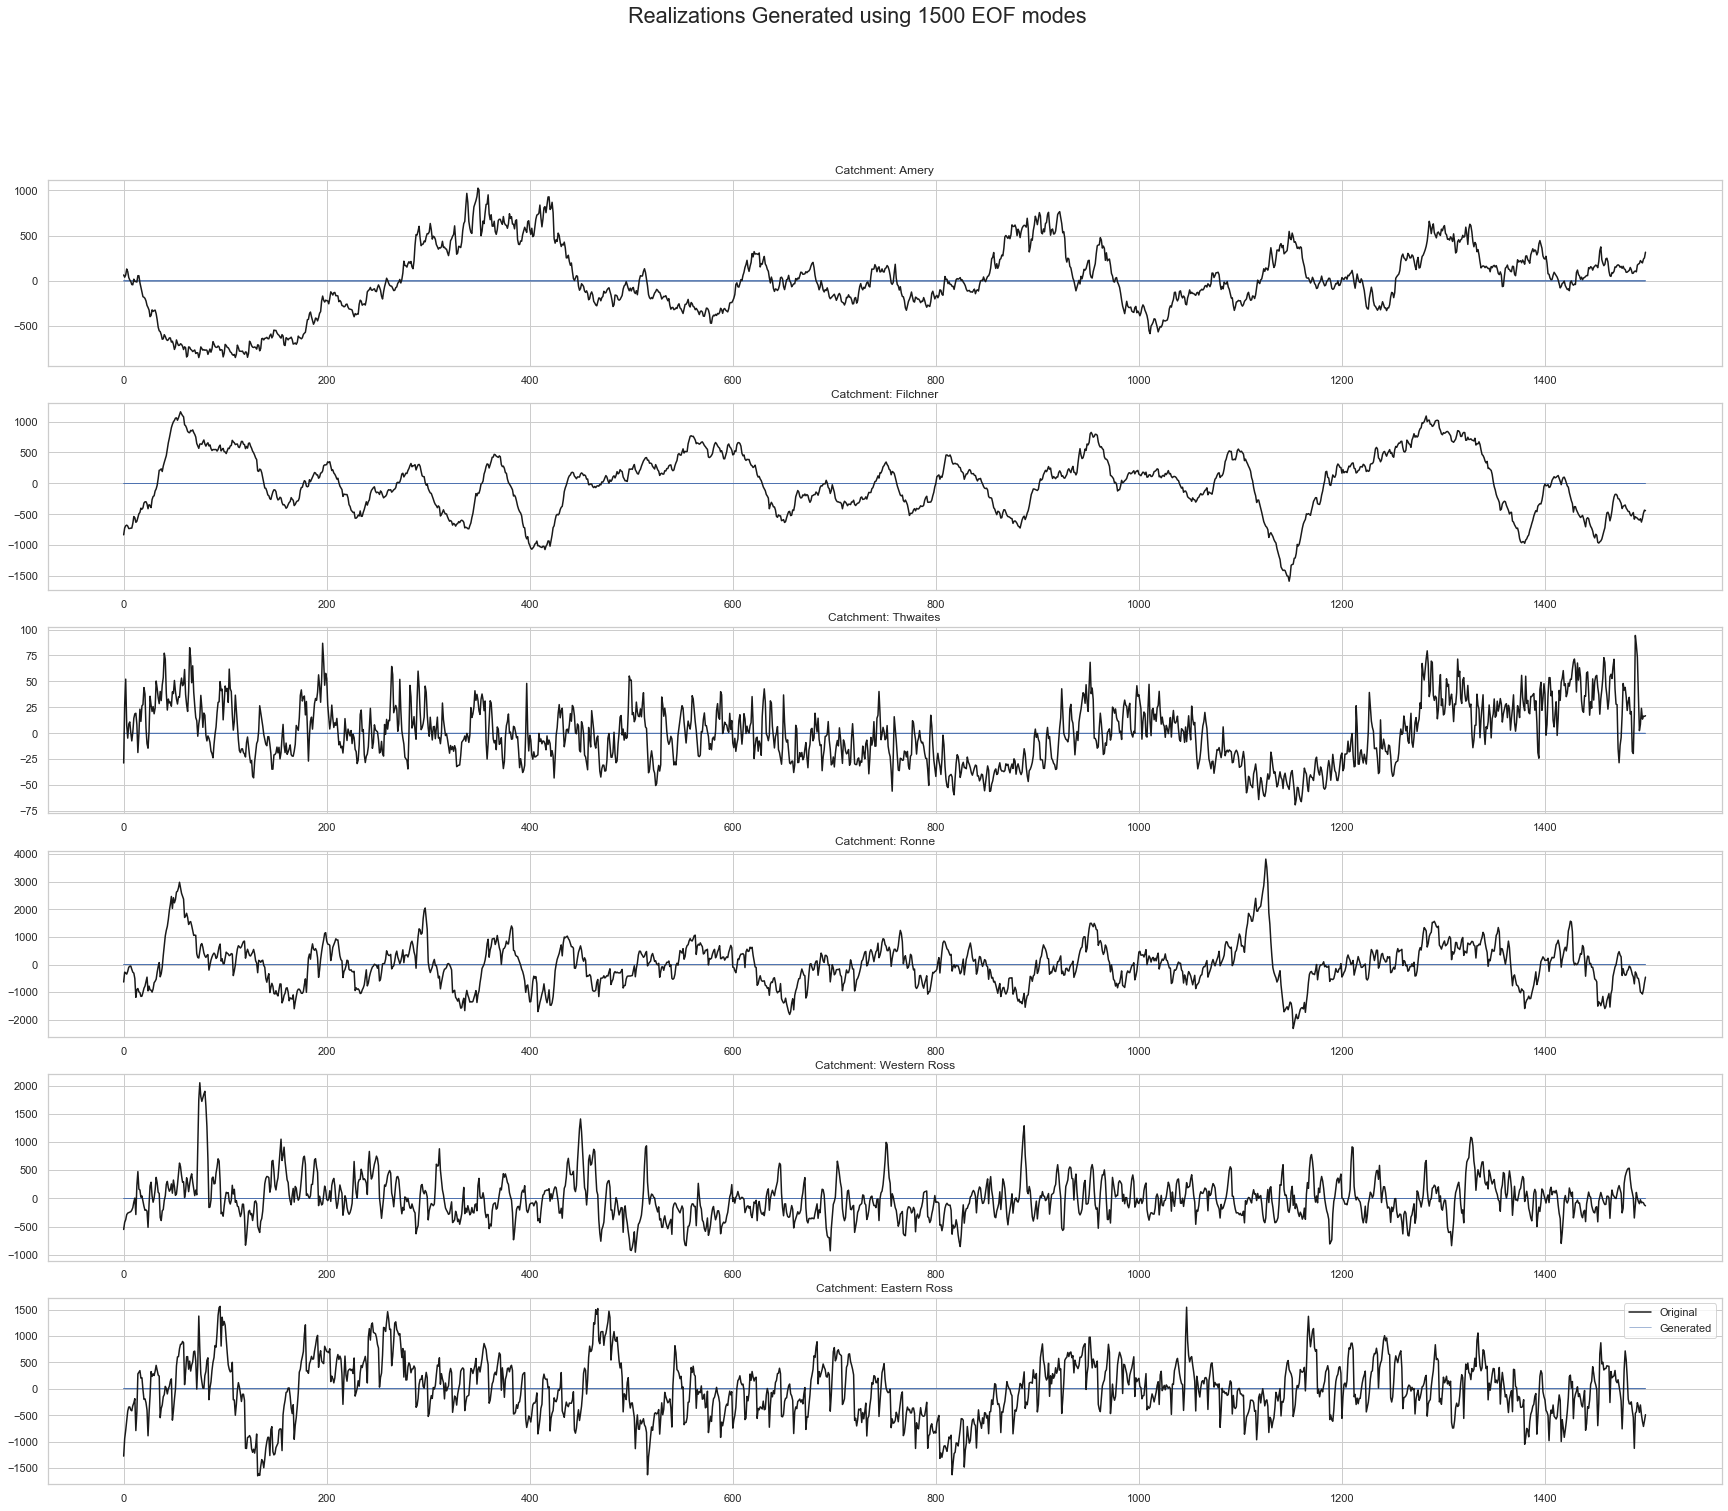

In [107]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_34_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[0].plot(rec1_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec2_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec3_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec4_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_55_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[1].plot(rec1_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec2_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec3_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec4_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_114_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[2].plot(rec1_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec2_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec3_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec4_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_103_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[3].plot(rec1_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec2_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec3_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec4_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_104_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[4].plot(rec1_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec2_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec3_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec4_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_105_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[5].plot(rec1_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec2_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec3_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec4_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 1500 EOF modes');

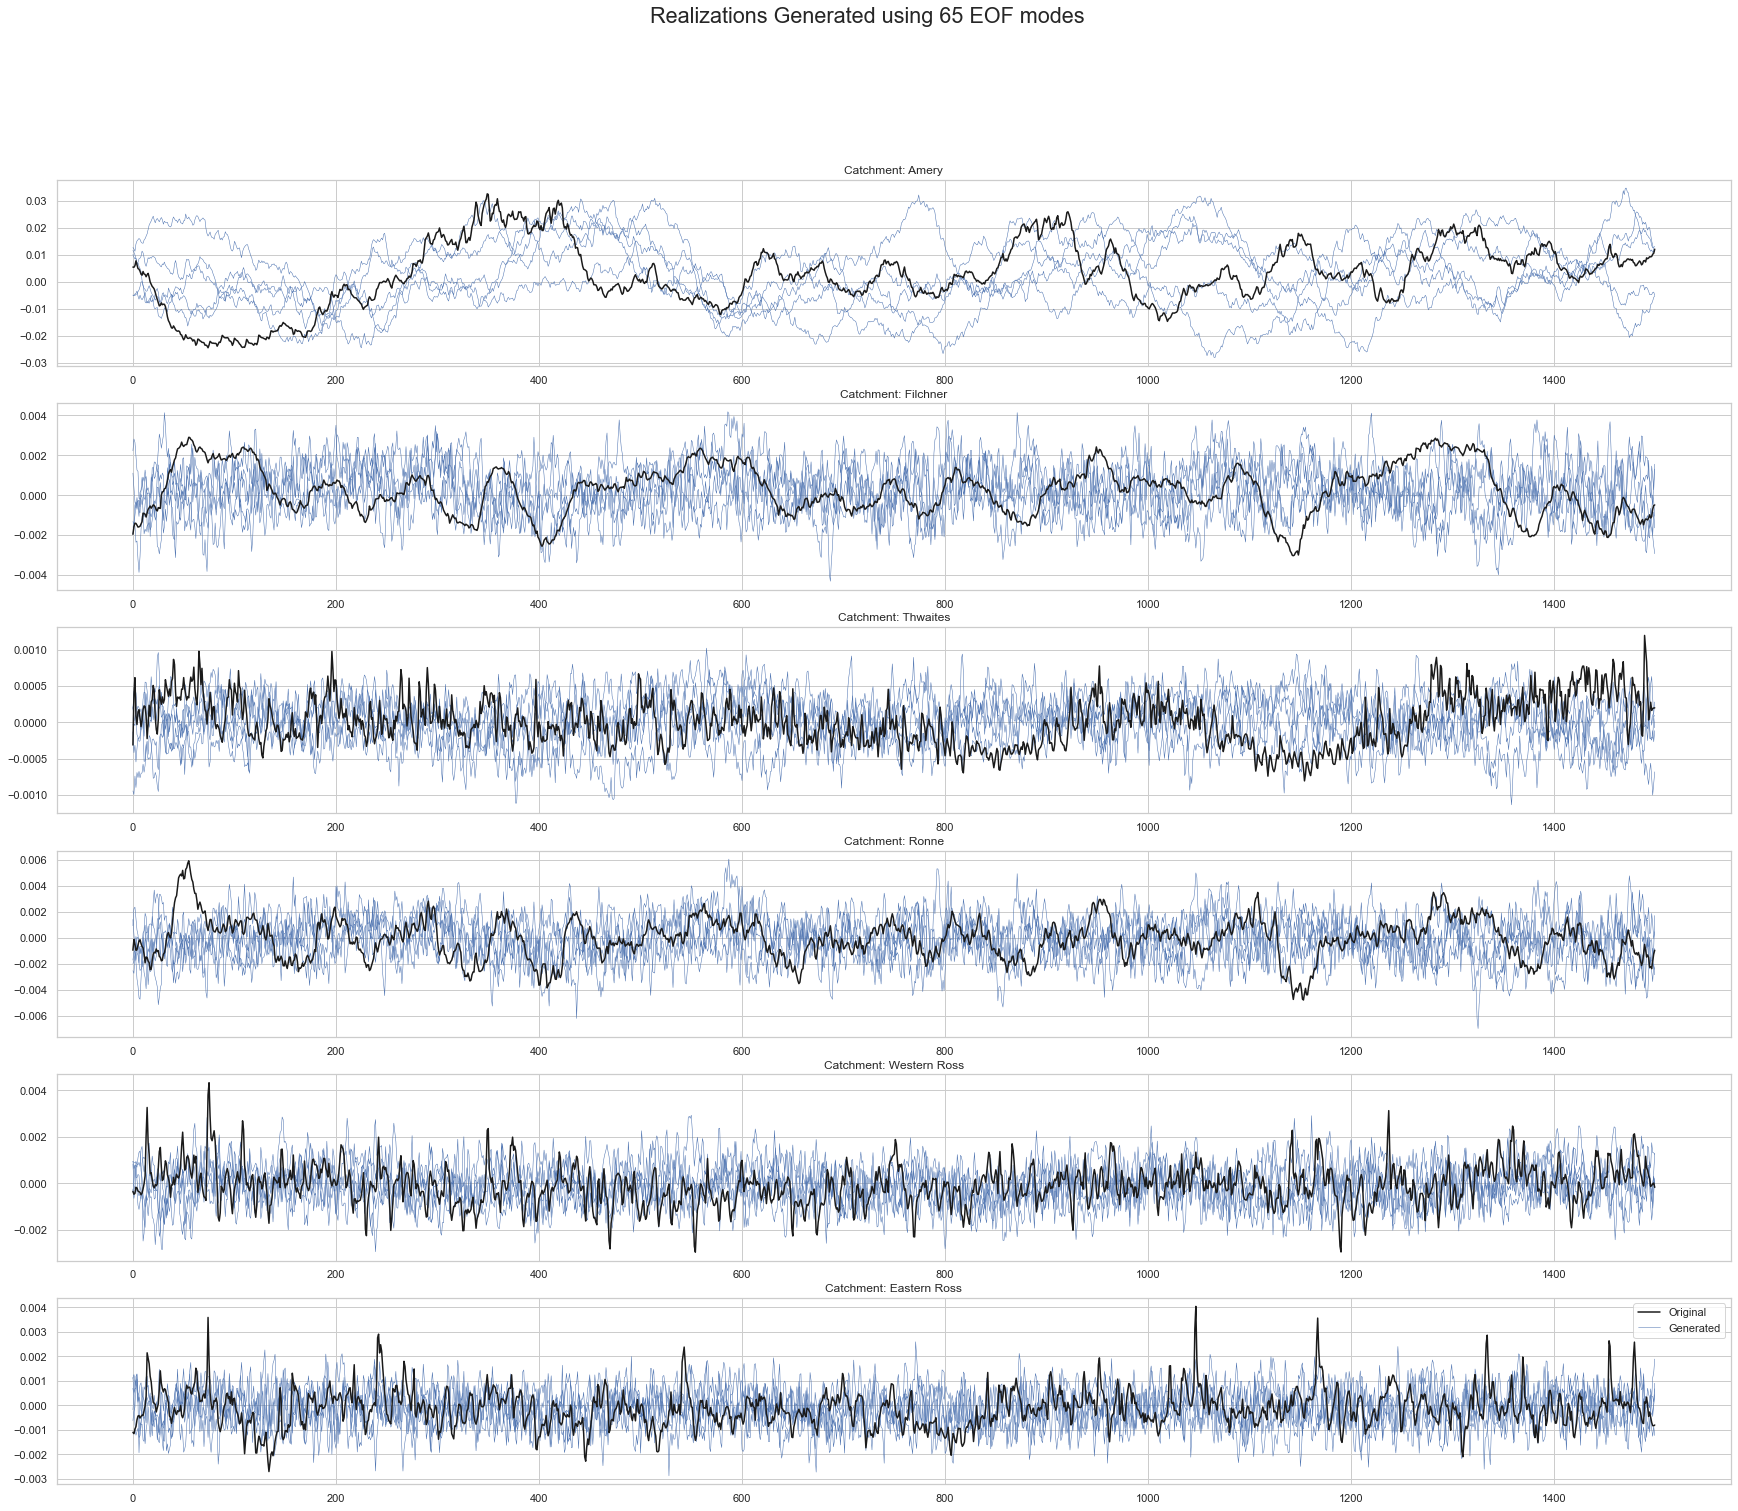

In [307]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_m65_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_m65_34_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[0].plot(rec1_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec2_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec3_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec4_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_m65_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_m65_55_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[1].plot(rec1_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec2_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec3_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec4_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_m65_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_m65_114_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[2].plot(rec1_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec2_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec3_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec4_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_m65_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_m65_103_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[3].plot(rec1_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec2_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec3_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec4_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_m65_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_m65_104_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[4].plot(rec1_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec2_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec3_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec4_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_m65_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_m65_105_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[5].plot(rec1_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec2_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec3_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec4_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 65 EOF modes');

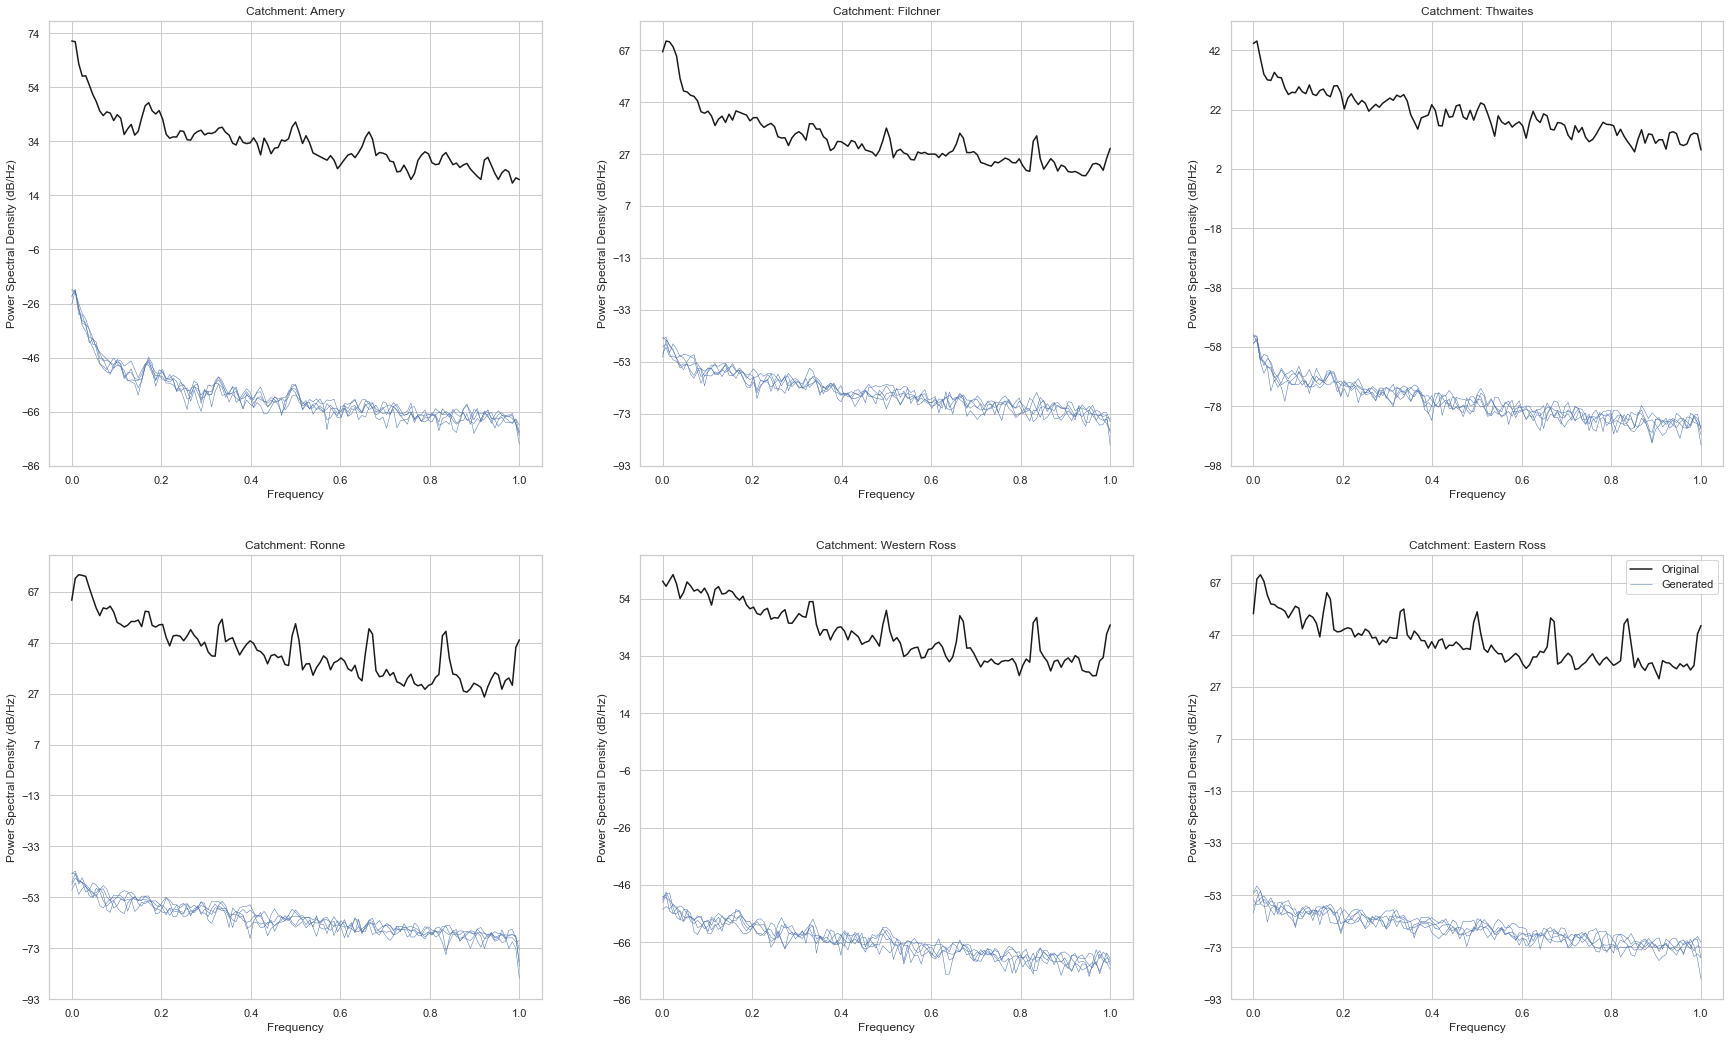

In [70]:
fig, axs = plt.subplots(2,3,figsize=(30,18))
axs=axs.ravel()

axs[0].psd(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[0].psd(rec0_34_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[0].psd(rec1_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec2_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec3_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec4_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].psd(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[1].psd(rec0_55_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[1].psd(rec1_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec2_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec3_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec4_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].psd(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[2].psd(rec0_114_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[2].psd(rec1_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec2_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec3_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec4_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].psd(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[3].psd(rec0_103_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[3].psd(rec1_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec2_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec3_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec4_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].psd(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[4].psd(rec0_104_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[4].psd(rec1_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec2_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec3_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec4_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].psd(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[5].psd(rec0_105_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[5].psd(rec1_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec2_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec3_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec4_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

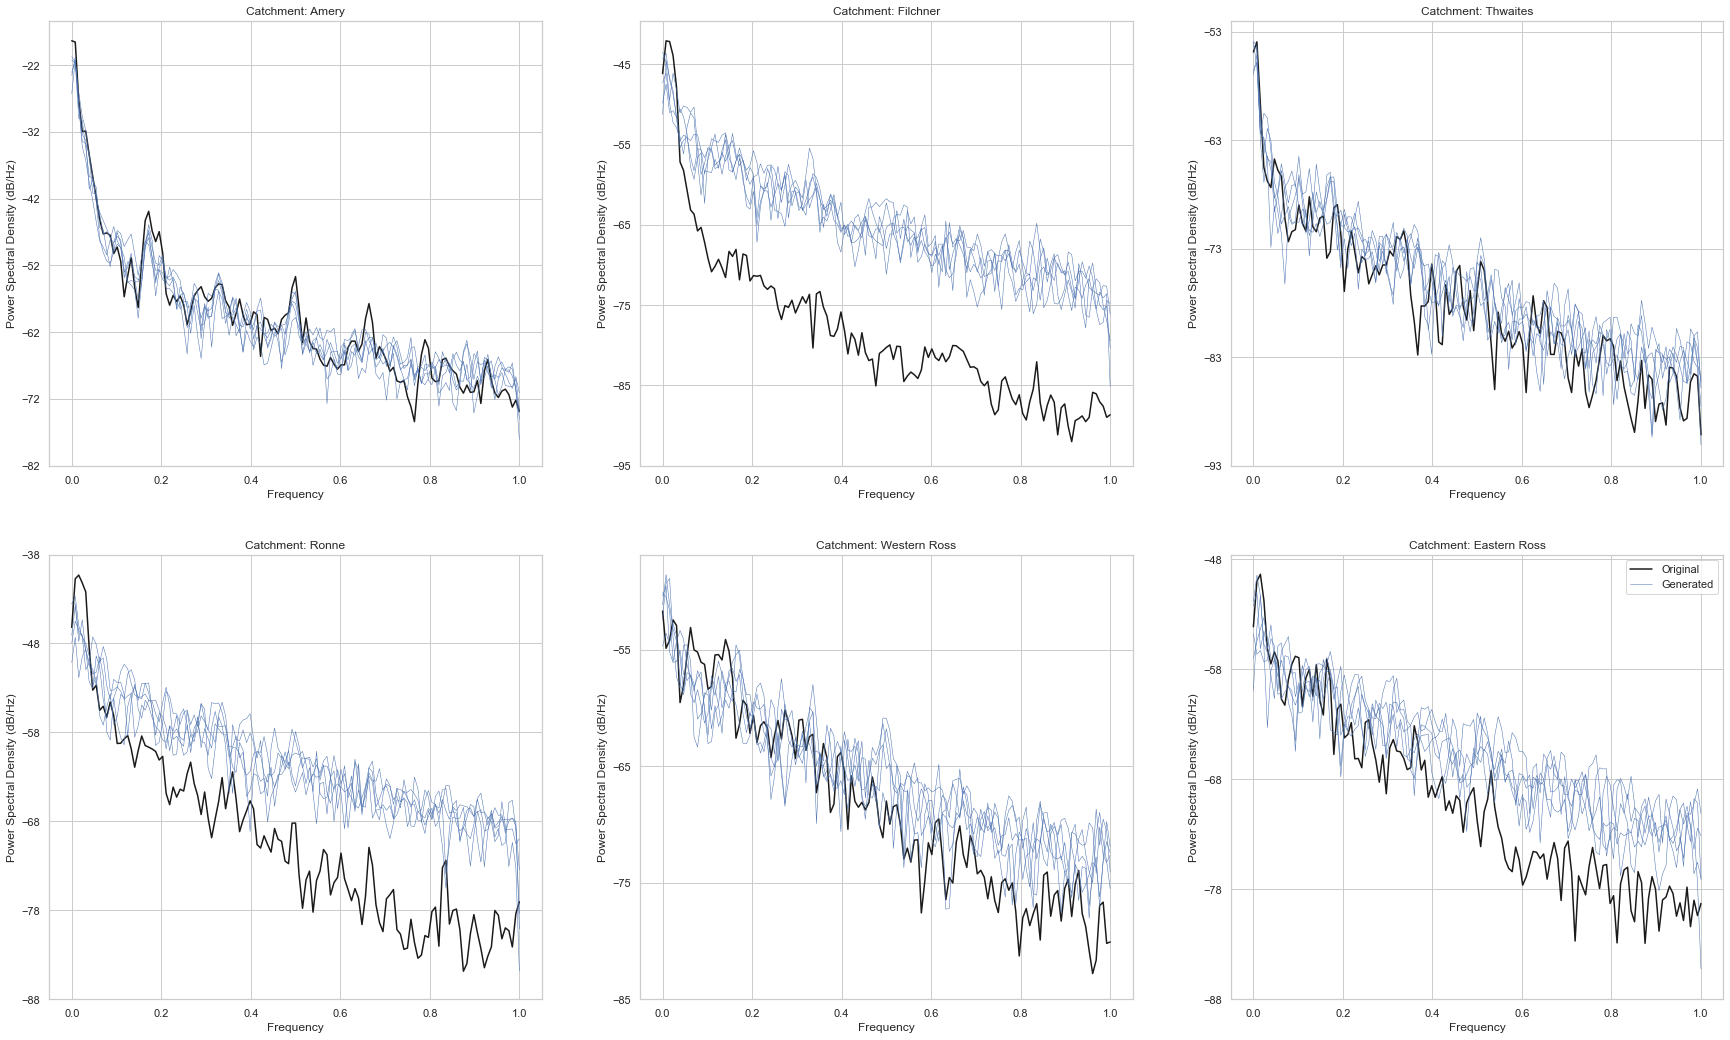

In [308]:
fig, axs = plt.subplots(2,3,figsize=(30,18))
axs=axs.ravel()

axs[0].psd(orig_m65_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[0].psd(rec0_m65_34_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[0].psd(rec1_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec2_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec3_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].psd(rec4_m65_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].psd(orig_m65_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[1].psd(rec0_m65_55_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[1].psd(rec1_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec2_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec3_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].psd(rec4_m65_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].psd(orig_m65_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[2].psd(rec0_m65_114_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[2].psd(rec1_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec2_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec3_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].psd(rec4_m65_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].psd(orig_m65_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[3].psd(rec0_m65_103_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[3].psd(rec1_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec2_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec3_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].psd(rec4_m65_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].psd(orig_m65_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[4].psd(rec0_m65_104_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[4].psd(rec1_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec2_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec3_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].psd(rec4_m65_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].psd(orig_m65_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[5].psd(rec0_m65_105_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[5].psd(rec1_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec2_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec3_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].psd(rec4_m65_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

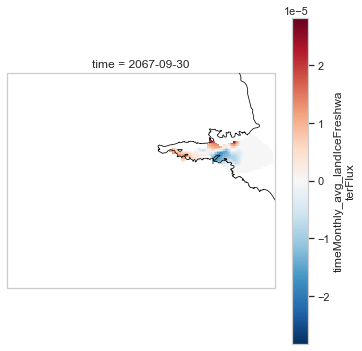

In [277]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6],subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
orig_34.timeMonthly_avg_landIceFreshwaterFlux[500].plot(ax=ax)